In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gamma, norm, lognorm
import seaborn as sns
from mgs import BioProject, Enrichment, MGSData
from datetime import date

In [2]:
df = pd.read_table("fits/rothman-sars_cov_2.tsv")
df = pd.wide_to_long(
    df, 
    stubnames=["y_tilde", "theta"], 
    i="draws", 
    j="sample", 
    sep=".",
)
df.reset_index(inplace=True)

In [3]:
bioproject = BioProject("PRJNA729801")

mgs_data = MGSData.from_repo()
attrs = list(
    mgs_data.sample_attributes(
        bioproject,
        enrichment=Enrichment.VIRAL,
    ).values()
)

def get_sample_attrs(attr: str):
    f = lambda i: getattr(attrs[i - 1], attr)
    return np.vectorize(f)

In [4]:
df["date"] = get_sample_attrs("date")(df["sample"])
df["county"] = get_sample_attrs("county")(df["sample"])
df["plant"] = get_sample_attrs("fine_location")(df["sample"])
df["total_reads"] = get_sample_attrs("reads")(df["sample"])

df["viral_reads"] = df["y_tilde"]
df["prevalence_per100k"] = np.exp(df["theta"])
df["ra_per_one_percent"] = 1_000 * np.exp(df["b"])
df["observation_type"] = "posterior"

In [5]:
OBSDRAWS = -1 # For faceting on draws
df_obs = pd.read_table("covid_input.tsv")
df_obs["date"] = list(map(date.fromisoformat, df_obs["date"]))
df_obs["draws"] = OBSDRAWS
df = pd.concat([df,df_obs], ignore_index = True)

df["reads_per_prev"] = df["viral_reads"] / df["prevalence_per100k"]

## Inverse overdispersion, $\phi$

<Axes: xlabel='phi', ylabel='Density'>

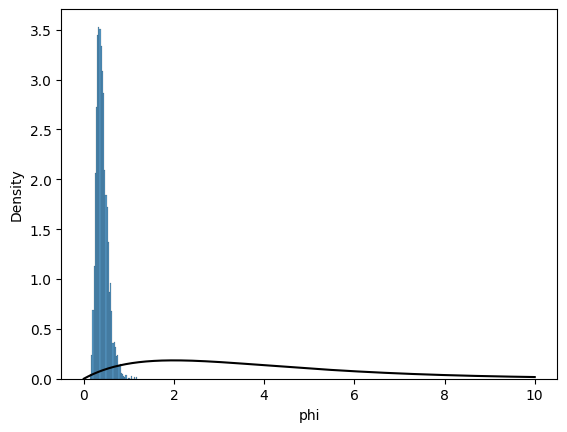

In [6]:
# Prior
x = np.linspace(0, 10, 1000)
sns.lineplot(
    x = x,
    y = gamma.pdf(x, 2.0, scale=2.0),
    color = "black",
)

# Posterior
sns.histplot(
    data=df[df["sample"] == 1],
    x="phi",
    stat="density",
    bins=40,
)

## Relative abundance per 1% prevalence

<Axes: xlabel='ra_per_one_percent', ylabel='Density'>

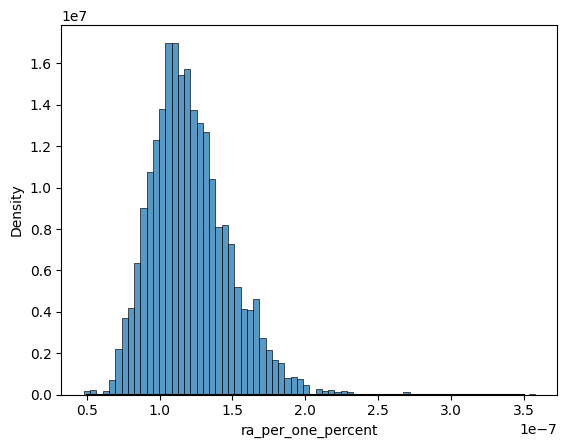

In [7]:
# Prior
x = np.linspace(0.5e-7, 3.5e-7, 1000)
sns.lineplot(
    x = x,
    y = lognorm.pdf(x, 10, loc=-3),
    color = "black",
)

# Posterior
sns.histplot(
    data=df[df["sample"] == 1],
    x="ra_per_one_percent",
    stat="density",
)

## Viral reads over time

0    0.530626
Name: phi, dtype: float64
1    0.877209
Name: phi, dtype: float64
2    0.44079
Name: phi, dtype: float64
3    0.290392
Name: phi, dtype: float64
4    0.308813
Name: phi, dtype: float64
5    0.401637
Name: phi, dtype: float64
6    0.325205
Name: phi, dtype: float64
7    0.511062
Name: phi, dtype: float64
8    0.283307
Name: phi, dtype: float64


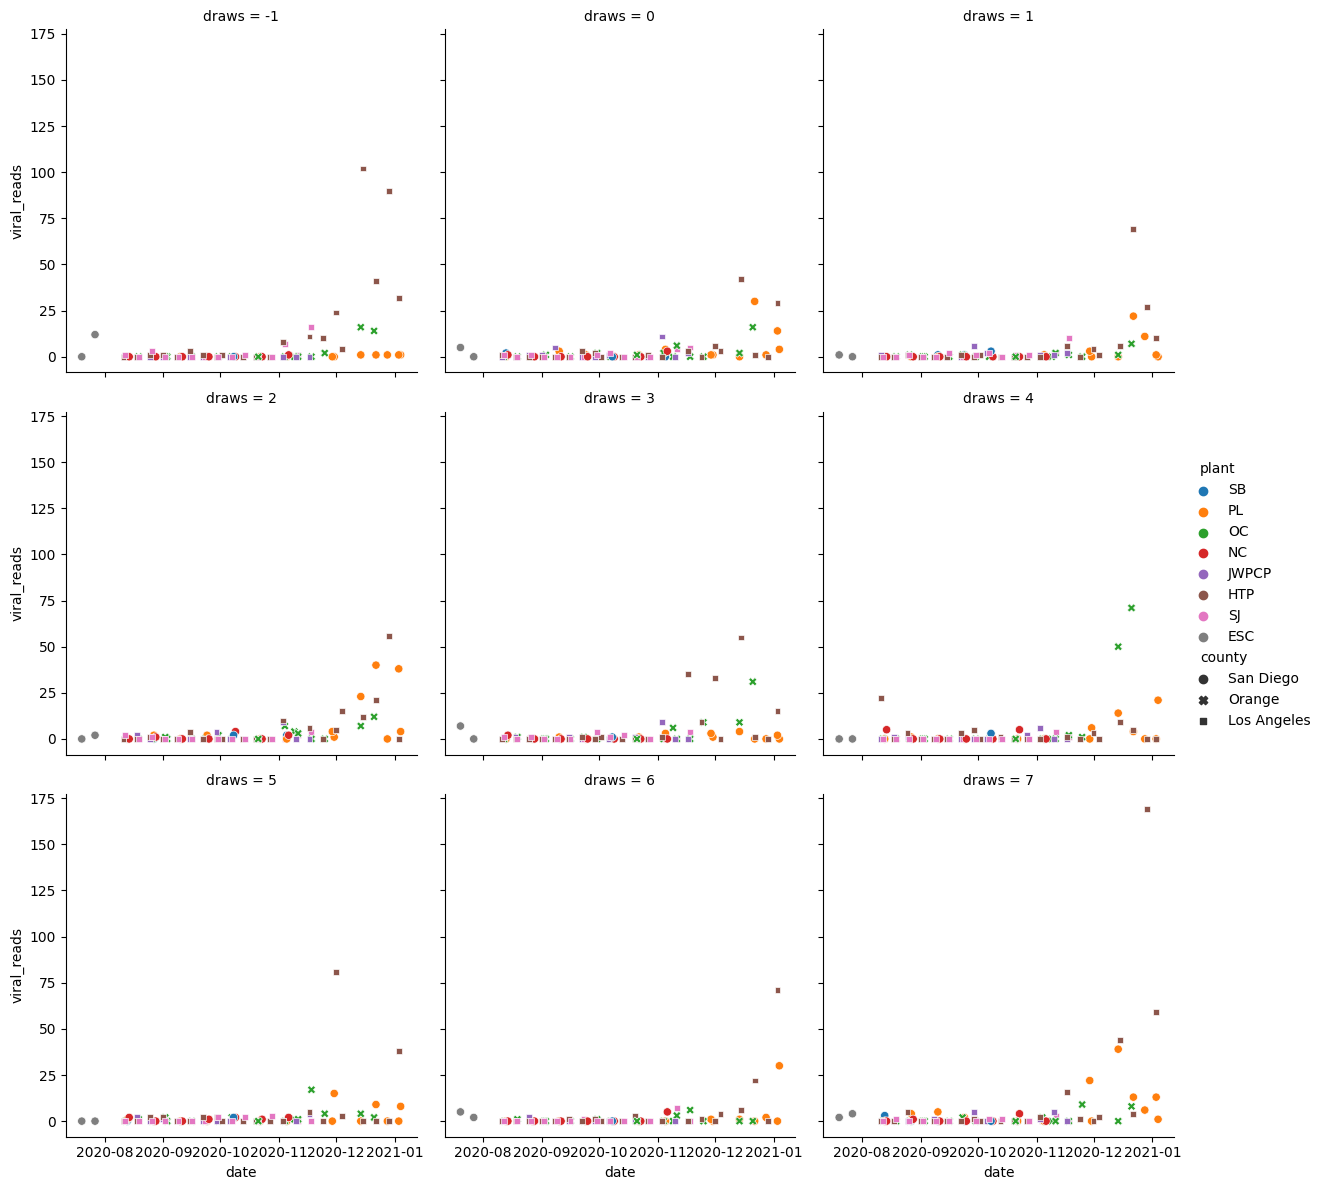

In [8]:
for d in range(9):
    print(df[(df["draws"] == d) & (df["sample"] == 1)]["phi"])

sns.relplot(
    data=df[(df["draws"] < 8) | (df["observation_type"] == "data")],
    col_wrap=3,
    col="draws",
    x="date",
    y="viral_reads",
    hue="plant",
    style="county",
    legend=True,
    height=4,
)

## Prevalence vs time

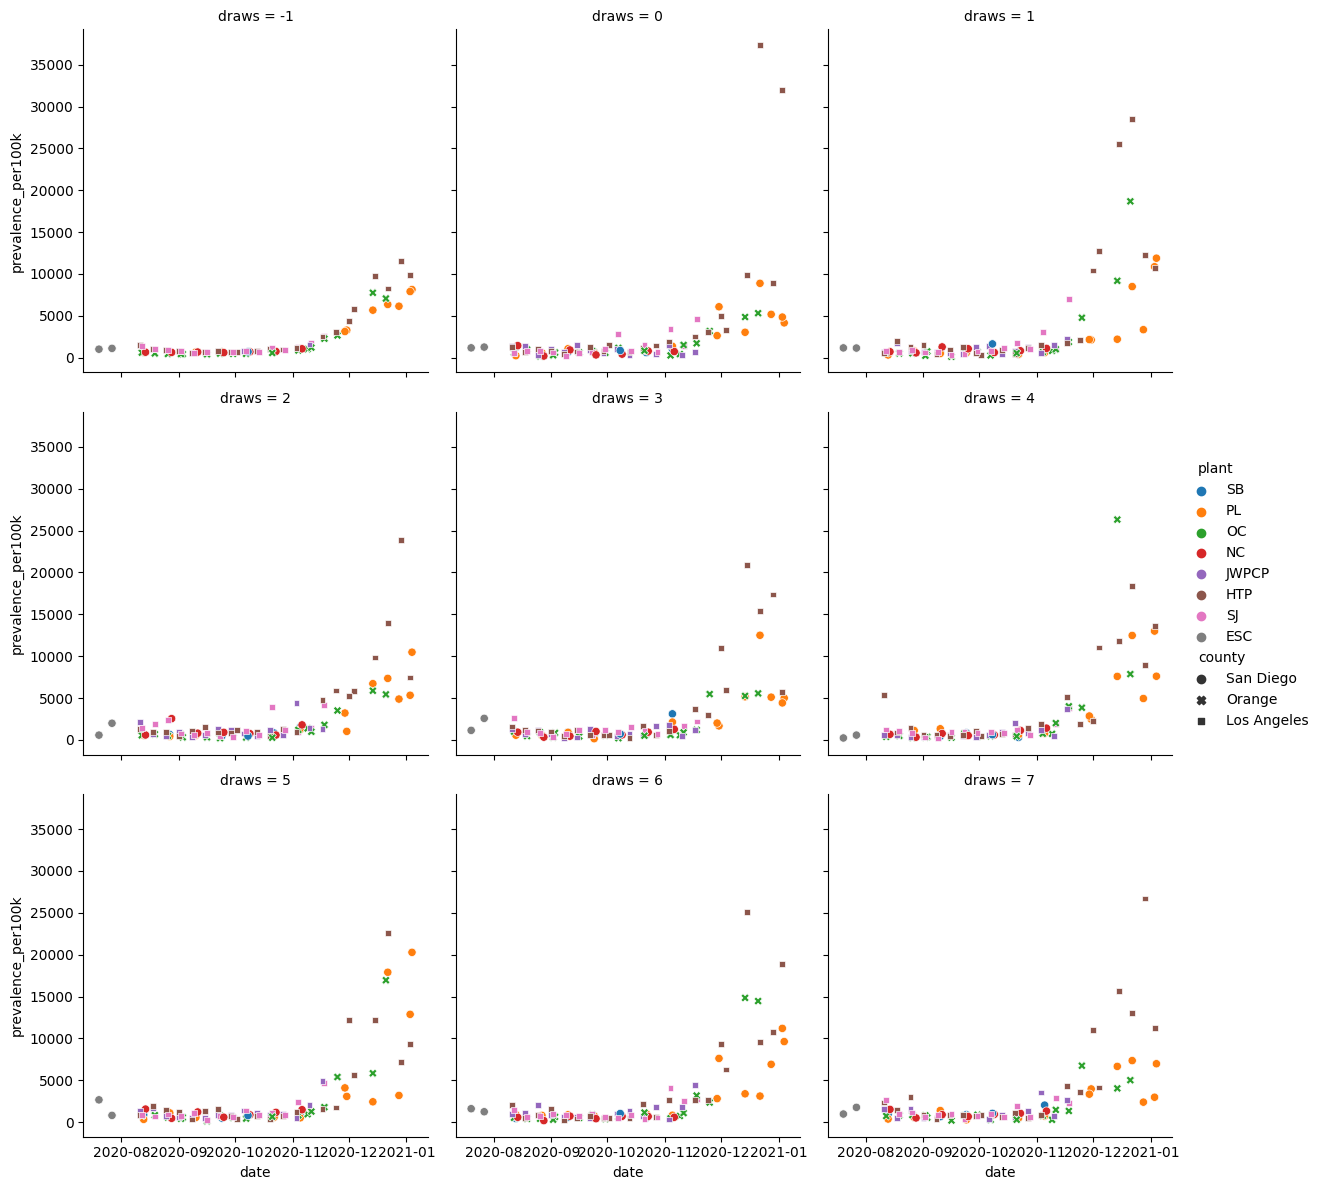

In [9]:
sns.relplot(
    data=df[(df["draws"] < 8) | (df["observation_type"] == "data")],
    col_wrap=3,
    col="draws",
    x="date",
    y="prevalence_per100k",
    hue="plant",
    style="county",
    legend=True,
    height=4,
)

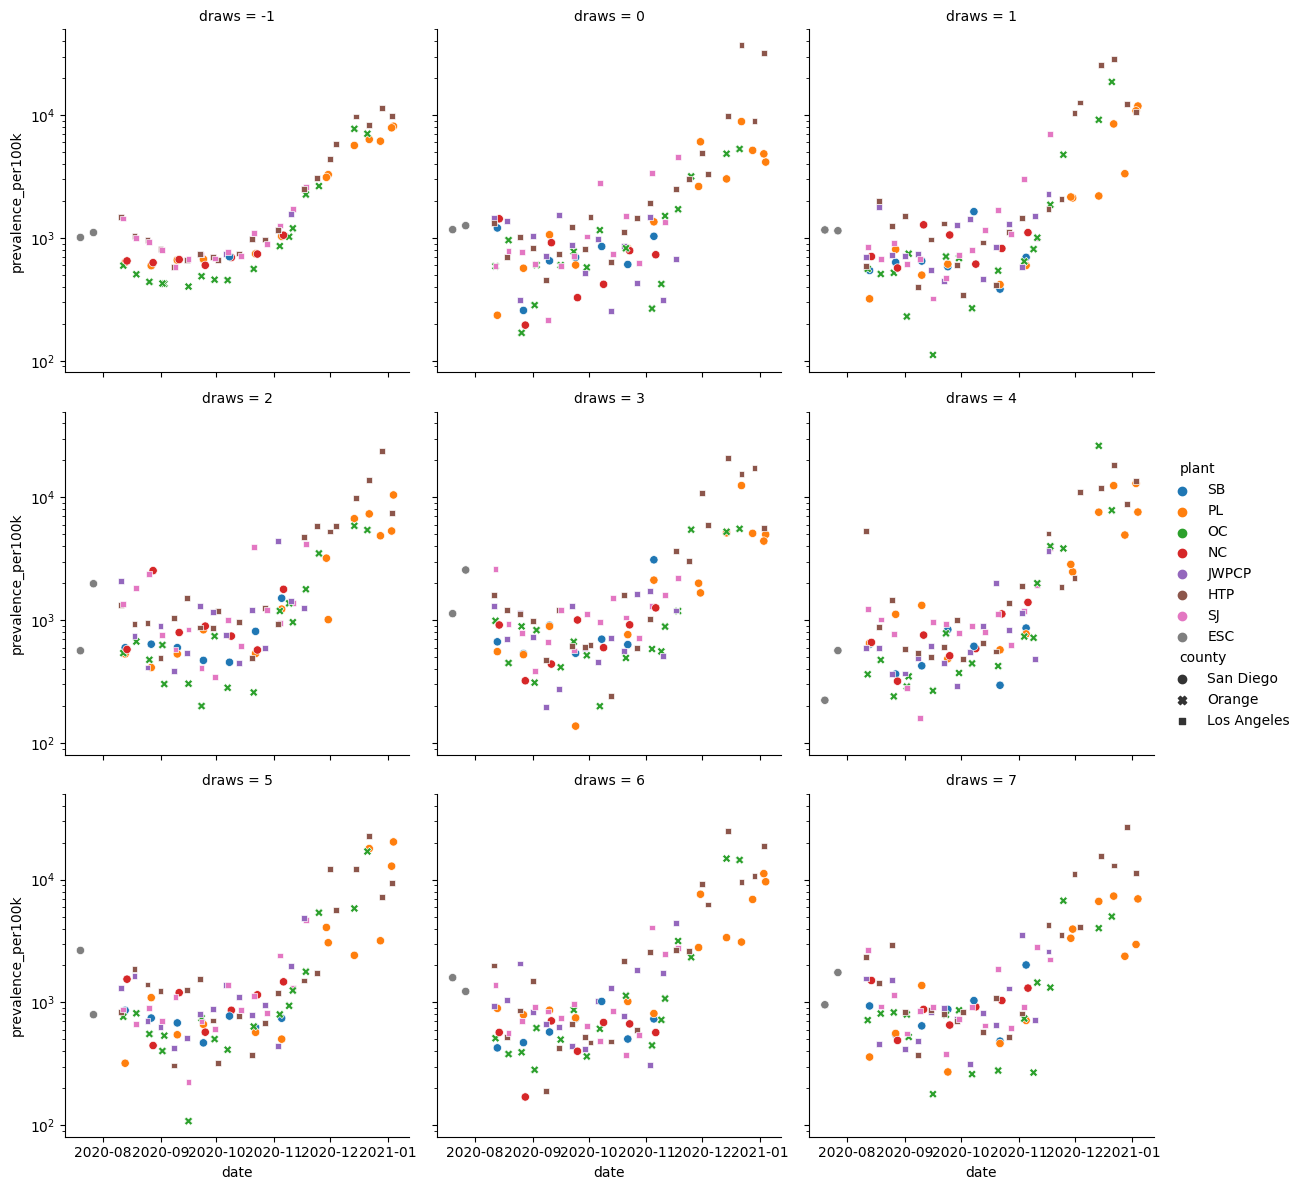

In [10]:
g = sns.relplot(
    data=df[(df["draws"] < 8) | (df["observation_type"] == "data")],
    col_wrap=3,
    col="draws",
    x="date",
    y="prevalence_per100k",
    hue="plant",
    style="county",
    legend=True,
    height=4,
)
g.set(yscale="log")

## Viral reads vs. prevalence

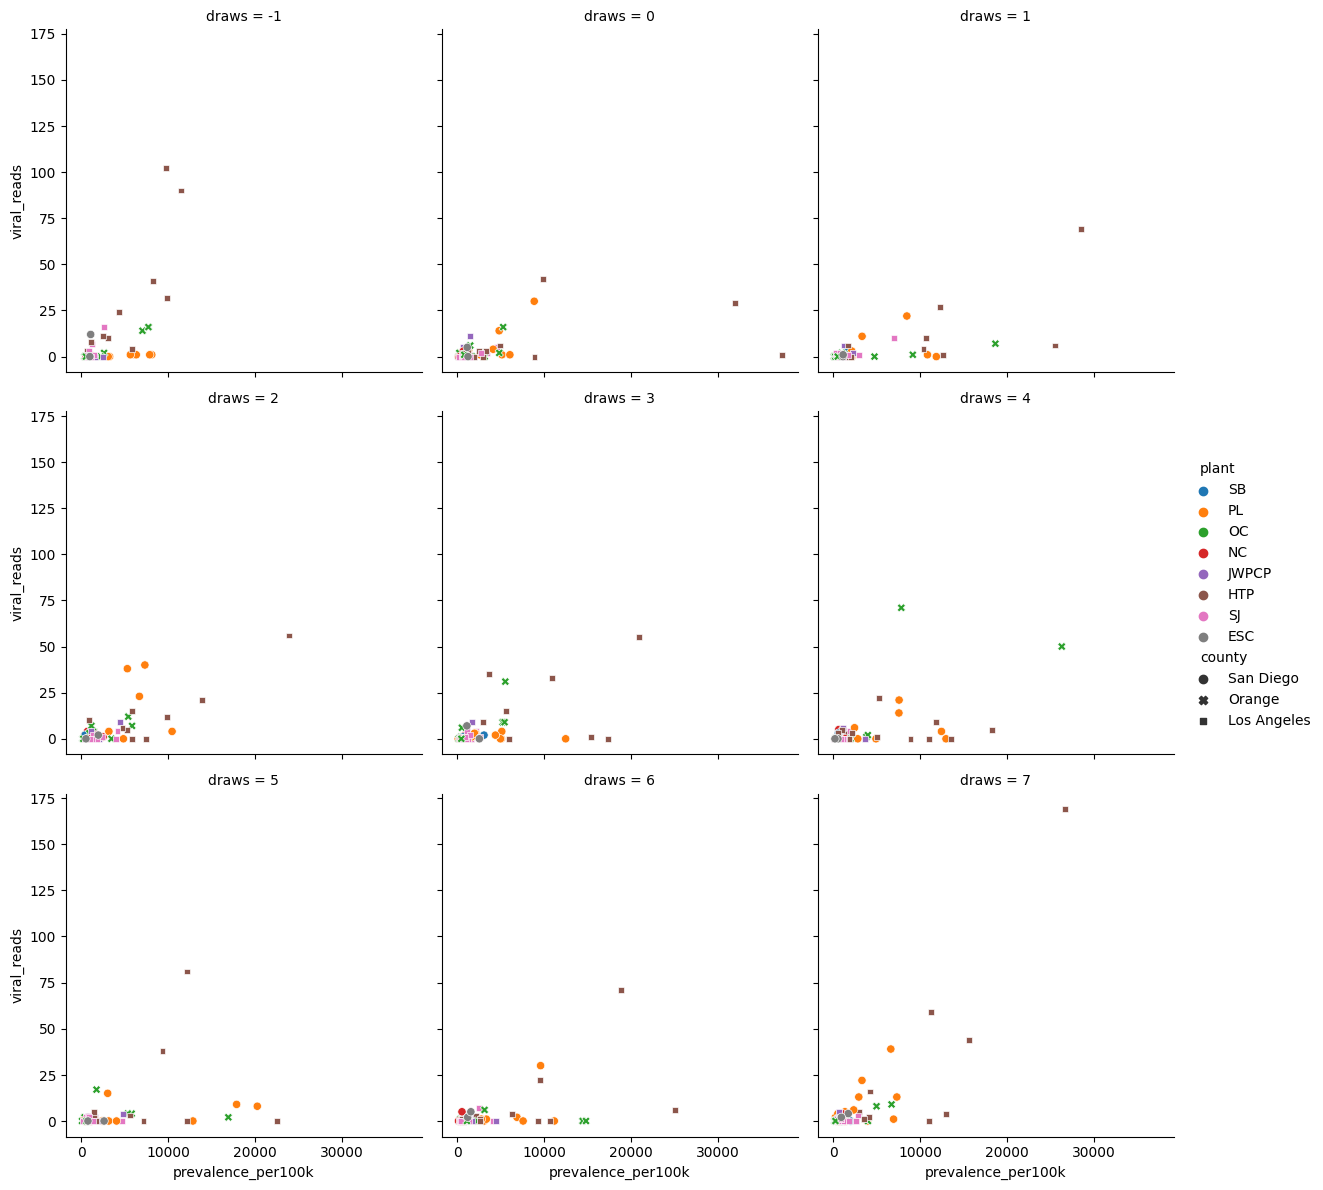

In [11]:
g = sns.relplot(
    data=df[(df["draws"] < 8) | (df["observation_type"] == "data")],
    col_wrap=3,
    col="draws",
    x="prevalence_per100k",
    y="viral_reads",
    hue="plant",
    style="county",
    legend=True,
    height=4,
)
# g.set(yscale="log")